[nltk_data] Downloading package stopwords to C:\Users\SION
[nltk_data]     RANI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Random Forest Classifier Performance
Accuracy: 0.9802690582959641
Precision: 1.0
Recall: 0.8533333333333334
F1 Score: 0.920863309352518

Naive Bayes Classifier Performance
Accuracy: 0.9748878923766816
Precision: 1.0
Recall: 0.8133333333333334
F1 Score: 0.8970588235294118


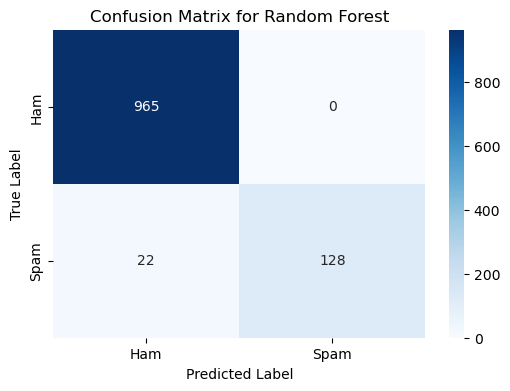

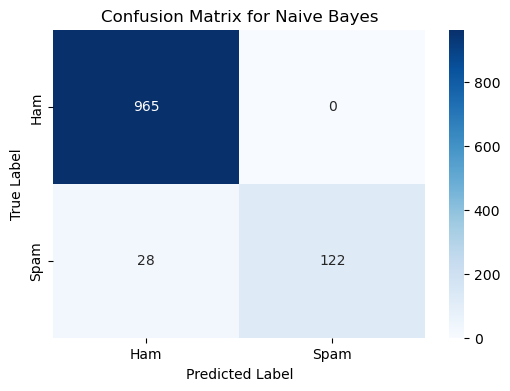


Random Forest Cross-Validation Scores: [0.9809417  0.98318386 0.98428732 0.96969697 0.97194164]
Mean Cross-Validation Score (Random Forest): 0.9780102972928084

Naive Bayes Cross-Validation Scores: [0.97982063 0.98542601 0.96632997 0.9708193  0.97643098]
Mean Cross-Validation Score (Naive Bayes): 0.9757653767369762


In [1]:
# Importing necessary libraries
import pandas as pd
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

# Load the dataset
file_path = 'spam.csv'  # Assuming the file is named spam.csv and in the current directory
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Data cleaning: Keep only the relevant columns and rename them
data_cleaned = data[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'message'})

# Preprocessing function to clean the text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])
    return text

# Apply the preprocessing function to the message column
data_cleaned['cleaned_message'] = data_cleaned['message'].apply(preprocess_text)

# Encode labels (spam = 1, ham = 0)
label_encoder = LabelEncoder()
data_cleaned['label_encoded'] = label_encoder.fit_transform(data_cleaned['label'])

# Feature: Email length
data_cleaned['email_length'] = data_cleaned['message'].apply(len)

# Feature: Number of links in the email
def count_links(text):
    return len(re.findall(r'http[s]?://', text))

data_cleaned['num_links'] = data_cleaned['message'].apply(count_links)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_cleaned[['cleaned_message', 'email_length', 'num_links']], 
                                                    data_cleaned['label_encoded'], 
                                                    test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_message'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_message'])

# Combine the TF-IDF features with the additional metadata features
X_train_combined = np.hstack((X_train_tfidf.toarray(), X_train[['email_length', 'num_links']].values))
X_test_combined = np.hstack((X_test_tfidf.toarray(), X_test[['email_length', 'num_links']].values))

# Initialize and train the RandomForestClassifier with default parameters
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train)

# Make predictions with RandomForest
y_pred_rf = rf_model.predict(X_test_combined)

# Initialize and train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Make predictions with Naive Bayes
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate RandomForestClassifier
print("Random Forest Classifier Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))

# Evaluate Naive Bayes
print("\nNaive Bayes Classifier Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))
print("F1 Score:", f1_score(y_test, y_pred_nb))

# Visualize confusion matrix for RandomForest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Visualize confusion matrix for Naive Bayes
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Perform 5-fold cross-validation on Random Forest
cv_scores_rf = cross_val_score(rf_model, X_train_combined, y_train, cv=5)
print("\nRandom Forest Cross-Validation Scores:", cv_scores_rf)
print("Mean Cross-Validation Score (Random Forest):", cv_scores_rf.mean())

# Perform 5-fold cross-validation on Naive Bayes
cv_scores_nb = cross_val_score(nb_model, X_train_tfidf, y_train, cv=5)
print("\nNaive Bayes Cross-Validation Scores:", cv_scores_nb)
print("Mean Cross-Validation Score (Naive Bayes):", cv_scores_nb.mean())
